# Ch.4　Kernel Computation in Practice

In [ ]:
# Install skfda in advance 
!pip install cvxopt

In [ ]:
# The programs in Chapter 4 assume that the following are executed 
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import cvxopt
from cvxopt import solvers
from cvxopt import matrix
import matplotlib.pyplot as plt
from matplotlib import style
style.use("seaborn-ticks")
from numpy.random import randn  # normalized random number
from scipy.stats import norm

## 4.1　Kernel Ridge regression

In [ ]:
def alpha(k, x, y):
    n = len(x)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = k(x[i], x[j])
    return np.linalg.inv(K + 10e-5 * np.identity(n)).dot(y)
    # add 10^(-5) I to K to make it regular

### Example 63

In [ ]:
def k_p(x, y):        # Definition of Kernel 
    return (np.dot(x.T, y) + 1)**3


def k_g(x, y):        # Definition of Kernel
    return np.exp(-(x - y)**2 / 2)

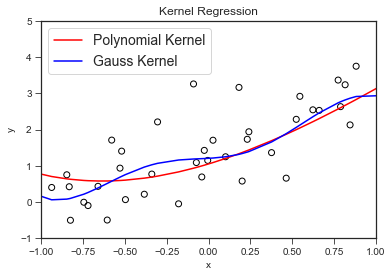

In [ ]:
lam = 0.1

# Data Generation
n = 50
x = np.random.randn(n)
y = 1 + x + x**2 + np.random.randn(n)

alpha_p = alpha(k_p, x, y)
alpha_g = alpha(k_g, x, y)

z = np.sort(x)
u = []
v = []
for j in range(n):
    S = 0
    for i in range(n):
        S = S + alpha_p[i] * k_p(x[i], z[j])
    u.append(S)
    S = 0
    for i in range(n):
        S = S + alpha_g[i] * k_g(x[i], z[j])
    v.append(S)

plt.scatter(x, y, facecolors="none", edgecolors="k", marker="o")
plt.plot(z, u, c="r", label="Polynomial Kernel")
plt.plot(z, v, c="b", label="Gauss Kernel")
plt.xlim(-1, 1)
plt.ylim(-1, 5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend(loc="upper left", frameon=True, prop={"size": 14})

In [ ]:
def alpha(k, x, y):
    n = len(x)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = k(x[i], x[j])
    return np.linalg.inv(K + lam * np.identity(n)).dot(y)

### Example 64

In [ ]:
def k_p(x, y):   # Definition of Kernel
    return (np.dot(x.T, y) + 1)**3


def k_g(x, y):   # Definition of Kernel
    return np.exp(-(x - y)**2 / 2)

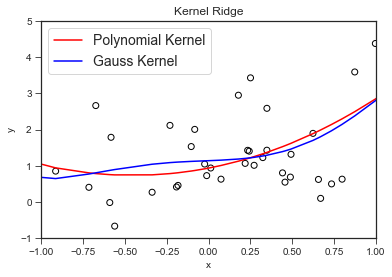

In [ ]:
lam = 0.1

# Data Generation
n = 50
x = np.random.randn(n)
y = 1 + x + x**2 + np.random.randn(n)

alpha_p = alpha(k_p, x, y)
alpha_g = alpha(k_g, x, y)

z = np.sort(x)
u = []
v = []
for j in range(n):
    S = 0
    for i in range(n):
        S = S + alpha_p[i] * k_p(x[i], z[j])
    u.append(S)
    S = 0
    for i in range(n):
        S = S + alpha_g[i] * k_g(x[i], z[j])
    v.append(S)
plt.scatter(x, y, facecolors="none", edgecolors="k", marker="o")
plt.plot(z, u, c="r", label="Polynomial Kernel")
plt.plot(z, v, c="b", label="Gauss Kernel")
plt.xlim(-1, 1)
plt.ylim(-1, 5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Ridge")
plt.legend(loc="upper left", frameon=True, prop={"size": 14})

## 4.2　Kernel Principal Component Analysis

In [ ]:
def kernel_pca_train(x, k):
    n = x.shape[0]
    K = np.zeros((n, n))
    S = [0] * n
    T = [0] * n
    for i in range(n):
        for j in range(n):
            K[i, j] = k(x[i, :], x[j, :])
    for i in range(n):
        S[i] = np.sum(K[i, :])
    for j in range(n):
        T[j] = np.sum(K[:, j])
    U = np.sum(K)
    for i in range(n):
        for j in range(n):
            K[i, j] = K[i, j] - S[i] / n - T[j] / n + U / n**2
    val, vec = np.linalg.eig(K)
    idx = val.argsort()[::-1]  # decreasing order as R
    val = val[idx]
    vec = vec[:, idx]
    alpha = np.zeros((n, n))
    for i in range(n):
        alpha[:, i] = vec[:, i] / val[i]**0.5
    return alpha

In [ ]:
def kernel_pca_test(x, k, alpha, m, z):
    n = x.shape[0]
    pca = np.zeros(m)
    for i in range(n):
        pca = pca + alpha[i, 0:m] * k(x[i, :], z)
    return pca

### Example 65

Text(-0.08750211763598995, -0.07575001678327324, '5')

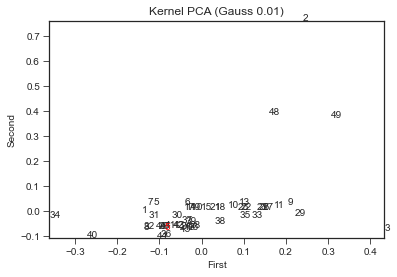

In [ ]:
# def k(x, y):
#     return np.dot(x.T, y)
sigma2 = 0.01


def k(x, y):
    return np.exp(-np.linalg.norm(x - y)**2 / 2 / sigma2)


X = pd.read_csv(
    "https://raw.githubusercontent.com/selva86/datasets/master/USArrests.csv")
x = X.values[:, :-1]
n = x.shape[0]
p = x.shape[1]
alpha = kernel_pca_train(x, k)
z = np.zeros((n, 2))

for i in range(n):
    z[i, :] = kernel_pca_test(x, k, alpha, 2, x[i, :])

min1 = np.min(z[:, 0])
min2 = np.min(z[:, 1])
max1 = np.max(z[:, 0])
max2 = np.max(z[:, 1])

plt.xlim(min1, max1)
plt.ylim(min2, max2)
plt.xlabel("First")
plt.ylabel("Second")
plt.title("Kernel PCA (Gauss 0.01)")
for i in range(n):
    if i != 4:
        plt.text(x=z[i, 0], y=z[i, 1], s=i)
plt.text(z[4, 0], z[4, 1], 5, c="r")

## 4.3　Kernel SVM

### Example 66

In [ ]:
def K_linear(x, y):
    return x.T @ y


def K_poly(x, y):
    return (1 + x.T @ y)**2


def svm_2(X, y, C, K):
    eps = 0.0001
    n = X.shape[0]
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            P[i, j] = K(X[i, :], X[j, :]) * y[i] * y[j]
    # Must be specified using the matrix function in the package
    P = matrix(P + np.eye(n) * eps)
    A = matrix(-y.T.astype(np.float))
    b = matrix(np.array([0]).astype(np.float))
    h = matrix(np.array([C] * n + [0] * n).reshape(-1, 1).astype(np.float))
    G = matrix(np.concatenate([np.diag(np.ones(n)), np.diag(-np.ones(n))]))
    q = matrix(np.array([-1] * n).astype(np.float))
    res = cvxopt.solvers.qp(P, q, A=A, b=b, G=G, h=h)
    alpha = np.array(res["x"])  # x corresponds to alpha in the text
    beta = ((alpha * y).T @ X).reshape(2, 1)
    index = (eps < alpha[:, 0]) & (alpha[:, 0] < C - eps)
    beta_0 = np.mean(y[index] - X[index, :] @ beta)
    return {"alpha": alpha, "beta": beta, "beta_0": beta_0}


def plot_kernel(K, line):  # Specify the line type with the parameter "line".
    res = svm_2(X, y, 1, K)
    alpha = res["alpha"][:, 0]
    beta_0 = res["beta_0"]

    def f(u, v):
        S = beta_0
        for i in range(X.shape[0]):
            S = S + alpha[i] * y[i] * K(X[i, :], [u, v])
        return S[0]
    # ww is the height at f(x,y). From this we can find the contour
    uu = np.arange(-2, 2, 0.1)
    vv = np.arange(-2, 2, 0.1)
    ww = []
    for v in vv:
        w = []
        for u in uu:
            w.append(f(u, v))
        ww.append(w)
    plt.contour(uu, vv, ww, levels=0, linestyles=line)

     pcost       dcost       gap    pres   dres
 0: -7.2292e+01 -5.2099e+02  3e+03  3e+00  9e-15
 1: -4.6032e+01 -3.4620e+02  6e+02  5e-01  6e-15
 2: -2.8614e+01 -1.2527e+02  2e+02  1e-01  8e-15
 3: -2.5048e+01 -4.3961e+01  3e+01  2e-02  6e-15
 4: -2.6800e+01 -3.2013e+01  7e+00  4e-03  3e-15
 5: -2.7516e+01 -2.8996e+01  2e+00  7e-04  3e-15
 6: -2.7876e+01 -2.8240e+01  4e-01  1e-04  3e-15
 7: -2.7977e+01 -2.8058e+01  9e-02  3e-05  3e-15
 8: -2.8002e+01 -2.8015e+01  2e-02  3e-06  3e-15
 9: -2.8007e+01 -2.8007e+01  4e-04  7e-08  3e-15
10: -2.8007e+01 -2.8007e+01  7e-06  1e-09  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.1436e+01 -4.5064e+02  2e+03  3e+00  2e-15
 1: -6.2437e+01 -2.8732e+02  4e+02  3e-01  2e-15
 2: -5.1296e+01 -9.9006e+01  6e+01  4e-02  1e-14
 3: -5.6734e+01 -6.7307e+01  1e+01  7e-03  2e-15
 4: -5.9337e+01 -6.2708e+01  4e+00  2e-03  1e-15
 5: -5.9955e+01 -6.1570e+01  2e+00  7e-04  2e-15
 6: -6.0333e+01 -6.0988e+01  7e-01  2e-04  1e-1

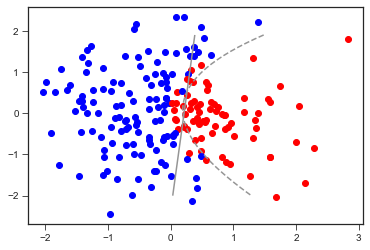

In [ ]:
a = 3
b = -1
n = 200
X = randn(n, 2)
y = np.sign(a * X[:, 0] + b * X[:, 1]**2 + 0.3 * randn(n))
y = y.reshape(-1, 1)
for i in range(n):
    if y[i] == 1:
        plt.scatter(X[i, 0], X[i, 1], c="red")
    else:
        plt.scatter(X[i, 0], X[i, 1], c="blue")
plot_kernel(K_poly, line="dashed")
plot_kernel(K_linear, line="solid")

## 4.4　Spline

### Example 67

In [ ]:
# Construct function d and h to find the basis

def d(j, x, knots):
    K = len(knots)
    return (np.maximum((x - knots[j])**3, 0)
            - np.maximum((x - knots[K-1])**3, 0)) / (knots[K-1] - knots[j])


def h(j, x, knots):
    K = len(knots)
    if j == 0:
        return 1
    elif j == 1:
        return x
    else:
        return d(j-1, x, knots) - d(K-2, x, knots)


# G is the value obtained by integrating a function differentiated twice
def G(x):    # Assuming that each value of x is in ascending order
    n = len(x)
    g = np.zeros((n, n))
    for i in range(2, n-1):
        for j in range(i, n):
            g[i, j] = 12 * (x[n-1] - x[n-2]) * (x[n-2] - x[j-2])\
                * (x[n-2] - x[i-2]) / (x[n-1] - x[i-2])\
                / (x[n-1] - x[j-2]) + (12*x[n-2] + 6*x[j-2] - 18*x[i-2])\
                * (x[n-2] - x[j-2])**2 / (x[n-1] - x[i-2]) / (x[n-1]-x[j-2])
            g[j, i] = g[i, j]
    return g

Text(0.5, 1.0, 'smooth spline (n = 100)')

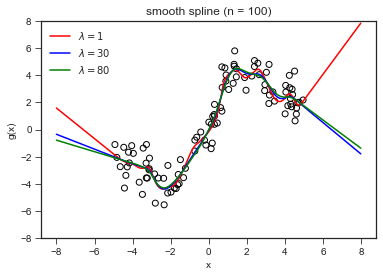

In [ ]:
# Main Process
n = 100
x = np.random.uniform(-5, 5, n)
y = x + np.sin(x)*2 + np.random.randn(n)   # Data Generation
index = np.argsort(x)
x = x[index]
y = y[index]
X = np.zeros((n, n))
X[:, 0] = 1
for j in range(1, n):
    for i in range(n):
        X[i, j] = h(j, x[i], x)            # Generate matrix X
GG = G(x)                                  # Generate matrix G
lam_set = [1, 30, 80]
col_set = ["red", "blue", "green"]

plt.figure()
plt.ylim(-8, 8)
plt.xlabel("x")
plt.ylabel("g(x)")

for i in range(3):
    lam = lam_set[i]
    gamma = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + lam * GG), X.T), y)

    def g(u):
        S = gamma[0]
        for j in range(1, n):
            S = S + gamma[j] * h(j, u, x)
        return S
    u_seq = np.arange(-8, 8, 0.02)
    v_seq = []
    for u in u_seq:
        v_seq.append(g(u))
    plt.plot(u_seq, v_seq, c=col_set[i], label=r"$\lambda = %d$" % lam_set[i])
plt.legend()
plt.scatter(x, y, facecolors="none", edgecolors="k", marker="o")
plt.title("smooth spline (n = 100)")

## 4.5　Random Fourier Features

### Example 68

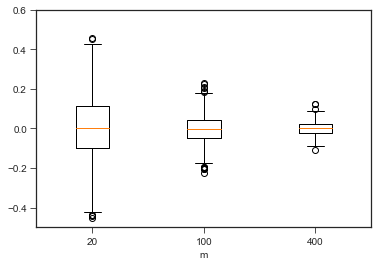

In [ ]:
sigma = 10
sigma2 = sigma**2


def k(x, y):
    return np.exp(-(x-y)**2 / (2 * sigma2))


def z(x):
    return np.sqrt(2/m) * np.cos(w*x+b)


def zz(x, y):
    return np.sum(z(x) * z(y))


u = np.zeros((1000, 3))
m_seq = [20, 100, 400]
for i in range(1000):
    x = randn(1)
    y = randn(1)
    for j in range(3):
        m = m_seq[j]
        w = randn(m) / sigma
        b = np.random.rand(m) * 2 * np.pi
        u[i, j] = zz(x, y) - k(x, y)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot([u[:, 0], u[:, 1], u[:, 2]], labels=["20", "100", "400"])
ax.set_xlabel("m")
ax.set_ylim(-0.5, 0.6)
plt.show()

### Example 69

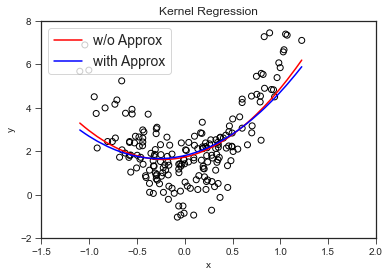

In [ ]:
sigma = 10
sigma2 = sigma**2

# Function z
m = 20
w = randn(m) / sigma
b = np.random.rand(m) * 2 * np.pi


def z(u, m):
    return np.sqrt(2/m) * np.cos(w * u + b)


# Gauss Kernel
def k(x, y):
    return np.exp(-(x-y)**2 / (2 * sigma2))


# Data Generation
n = 200
x = randn(n) / 2
y = 1 + 5 * np.sin(x/10) + 5 * x**2 + randn(n)
x_min = np.min(x)
x_max = np.max(x)
y_min = np.min(y)
y_max = np.max(y)
lam = 0.001
# lam = 0.9


# Function of low-rank approximation
def alpha_rff(x, y, m):
    n = len(x)
    Z = np.zeros((n, m))
    for i in range(n):
        Z[i, :] = z(x[i], m)
    beta = np.dot(np.linalg.inv(np.dot(Z.T, Z) + lam * np.eye(m)),
                  np.dot(Z.T, y))
    return(beta)


# Normal Function
def alpha(k, x, y):
    n = len(x)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = k(x[i], x[j])
    alpha = np.dot(np.linalg.inv(K + lam * np.eye(n)), y)
    return alpha


# Numerical Comparison
alpha_hat = alpha(k, x, y)
beta_hat = alpha_rff(x, y, m)
r = np.sort(x)
u = np.zeros(n)
v = np.zeros(n)
for j in range(n):
    S = 0
    for i in range(n):
        S = S + alpha_hat[i] * k(x[i], r[j])
    u[j] = S
    v[j] = np.sum(beta_hat * z(r[j], m))

plt.scatter(x, y, facecolors="none", edgecolors="k", marker="o")
plt.plot(r, u, c="r", label="w/o Approx")
plt.plot(r, v, c="b", label="with Approx")
plt.xlim(-1.5, 2)
plt.ylim(-2, 8)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend(loc="upper left", frameon=True, prop={"size": 14})

## 4.6　Nystr&ouml;m approximation


### Example 70

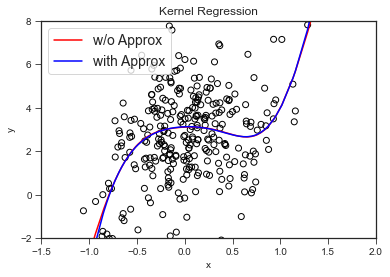

In [ ]:
sigma2 = 1


def k(x, y):
    return np.exp(-(x-y)**2 / (2 * sigma2))


n = 300
x = randn(n) / 2
y = 3 - 2 * x**2 + 3 * x**3 + 2 * randn(n)
lam = 10**(-5)
m = 10

K = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        K[i, j] = k(x[i], x[j])


# Function of low-rank approximation
def alpha_m(K, x, y, m):
    n = len(x)
    U, D, V = np.linalg.svd(K[:m, :m])
    u = np.zeros((n, m))
    for i in range(m):
        for j in range(n):
            u[j, i] = np.sqrt(m/n) * np.sum(K[j, :m] * U[:m, i] / D[i])
    mu = D * n / m
    R = np.zeros((n, m))
    for i in range(m):
        R[:, i] = np.sqrt(mu[i]) * u[:, i]
    Z = np.linalg.inv(np.dot(R.T, R) + lam * np.eye(m))
    alpha = np.dot((np.eye(n) - np.dot(np.dot(R, Z), R.T)), y) / lam
    return(alpha)


# Normal Function
def alpha(K, x, y):
    alpha = np.dot(np.linalg.inv(K + lam * np.eye(n)), y)
    return alpha


# Numerical Comparison
alpha_1 = alpha(K, x, y)
alpha_2 = alpha_m(K, x, y, m)
r = np.sort(x)
w = np.zeros(n)
v = np.zeros(n)
for j in range(n):
    S_1 = 0
    S_2 = 0
    for i in range(n):
        S_1 = S_1 + alpha_1[i] * k(x[i], r[j])
        S_2 = S_2 + alpha_2[i] * k(x[i], r[j])
    w[j] = S_1
    v[j] = S_2
plt.scatter(x, y, facecolors="none", edgecolors="k", marker="o")
plt.plot(r, w, c="r", label="w/o Approx")
plt.plot(r, v, c="b", label="with Approx")
plt.xlim(-1.5, 2)
plt.ylim(-2, 8)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend(loc="upper left", frameon=True, prop={"size": 14})

## 4.7　Incomplete Cholesky decomposition

In [ ]:
def im_ch(A, m):
    n = A.shape[1]
    R = np.zeros((n, n))
    P = np.eye(n)
    for i in range(m):
        max_R = -np.inf
        for j in range(i, n):
            RR = A[j, j]
            for h in range(i):
                RR = RR - R[j, h]**2
            if RR > max_R:
                k = j
                max_R = RR
        R[i, i] = np.sqrt(max_R)
        if k != i:
            for j in range(i):
                w = R[i, j]
                R[i, j] = R[k, j]
                R[k, j] = w
            for j in range(n):
                w = A[j, k]
                A[j, k] = A[j, i]
                A[j, i] = w
            for j in range(n):
                w = A[k, j]
                A[k, j] = A[i, j]
                A[i, j] = w
            Q = np.eye(n)
            Q[i, i] = 0
            Q[k, k] = 0
            Q[i, k] = 1
            Q[k, i] = 1
            P = np.dot(P, Q)
        if i < n:
            for j in range(i+1, n):
                S = A[j, i]
                for h in range(i):
                    S = S - R[i, h] * R[j, h]
                R[j, i] = S / R[i, i]
    return np.dot(P, R)

In [ ]:
# Data generation Allow A to be non-negative definite value
n = 5
D = np.matrix([[np.random.randint(-n, n) for i in range(n)] for j in range(n)])
A = np.dot(D, D.T)
A

matrix([[ 47,   2, -25, -11, -18],
        [  2,  40,  -6, -21, -12],
        [-25,  -6,  27,   8,  12],
        [-11, -21,   8,  50, -21],
        [-18, -12,  12, -21,  47]])

In [ ]:
L = im_ch(A, 5)
np.dot(L, L.T)

array([[ 47.,   2., -25., -11., -18.],
       [  2.,  40.,  -6., -21., -12.],
       [-25.,  -6.,  27.,   8.,  12.],
       [-11., -21.,   8.,  50., -21.],
       [-18., -12.,  12., -21.,  47.]])

In [ ]:
# Incomplete Cholesky decomposition with rank 3
L = im_ch(A, 3)
np.linalg.eig(A)

(array([82.77340824, 72.04487579,  3.81288314, 10.25781357, 42.11101927]),
 matrix([[-0.27317994,  0.7660152 ,  0.55200866,  0.18070534,  0.03500652],
         [ 0.63955121,  0.07590874,  0.38663629, -0.44084072, -0.49130841],
         [ 0.34911282, -0.27814841,  0.49196832,  0.05967017,  0.74509083],
         [-0.4562766 , -0.02198021,  0.07084621, -0.85707575,  0.22744343],
         [-0.43160037, -0.57411577,  0.54657736,  0.18672351, -0.38794295]]))

In [ ]:
# If you try to restore it, it won't return A
B = np.dot(L, L.T)
B

array([[ 50.        , -11.        , -21.        ,   8.        ,
        -21.        ],
       [-11.        ,  47.        ,   2.        , -25.        ,
        -18.        ],
       [-21.        ,   2.        ,  40.        ,  -6.        ,
        -12.        ],
       [  8.        , -25.        ,  -6.        ,  13.91244559,
         11.29178536],
       [-21.        , -18.        , -12.        ,  11.29178536,
         36.10983704]])

In [ ]:
# The first three eigenvalues of B are close to those of A
np.linalg.eig(B)

(array([7.89421470e+01+0.00000000e+00j, 6.79857638e+01+0.00000000e+00j,
        4.00943718e+01+0.00000000e+00j, 2.75186612e-15+3.04151101e-15j,
        2.75186612e-15-3.04151101e-15j]),
 array([[ 0.46477802+0.j        , -0.68886109+0.j        ,
         -0.13078191+0.j        , -0.03763862+0.40962613j,
         -0.03763862-0.40962613j],
        [-0.62929665+0.j        , -0.3115869 +0.j        ,
          0.47738305+0.j        ,  0.27195469+0.26767313j,
          0.27195469-0.26767313j],
        [-0.42046595+0.j        ,  0.2041816 +0.j        ,
         -0.76083386+0.j        ,  0.03628343+0.34784402j,
          0.03628343-0.34784402j],
        [ 0.38220146+0.j        ,  0.14572672+0.j        ,
         -0.15286987+0.j        ,  0.5681235 +0.j        ,
          0.5681235 -0.j        ],
        [ 0.2551422 +0.j        ,  0.6045309 +0.j        ,
          0.39085055+0.j        , -0.05192363+0.48724654j,
         -0.05192363-0.48724654j]]))

In [ ]:
# The rank of B is 3.
np.linalg.matrix_rank(B)

3